In [87]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [88]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [89]:
len(words)

32033

In [90]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [91]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [92]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [93]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [94]:
sum(p.nelement() for p in parameters)

11897

In [95]:
for p in parameters:
    p.requires_grad = True

In [96]:
lossi = []
stepi = []

for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # sample 32 at a time
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27])
    loss = F.cross_entropy(logits, Ytr[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1
    if i > 10000:
        lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.log10().item())

26.00714111328125
24.17379379272461
22.328771591186523
20.65168571472168
23.264707565307617
24.884857177734375
18.77774429321289
22.036510467529297
21.40244483947754
16.10386848449707
15.623635292053223
19.7930965423584
18.160491943359375
20.61858367919922
19.849708557128906
14.814648628234863
16.02239227294922
14.855646133422852
14.062459945678711
13.956818580627441
13.828229904174805
18.211149215698242
13.970919609069824
15.051828384399414
14.998675346374512
10.487334251403809
14.571388244628906
10.4235200881958
12.726497650146484
15.551729202270508
12.608755111694336
11.677703857421875
10.045315742492676
14.083952903747559
10.110799789428711
13.852190971374512
16.500009536743164
10.542777061462402
13.24278736114502
14.066332817077637
9.752192497253418
14.11247730255127
11.877513885498047
13.204327583312988
9.874943733215332
10.808622360229492
10.489031791687012
11.583967208862305
10.110098838806152
11.652044296264648
11.256659507751465
9.592707633972168
15.24351692199707
11.10075187

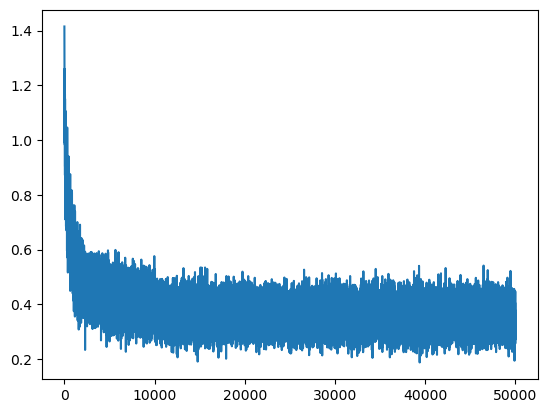

In [97]:
plt.plot(stepi, lossi)

In [98]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27])
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2895, grad_fn=<NllLossBackward0>)

In [99]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27])
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2938, grad_fn=<NllLossBackward0>)

In [100]:


# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

dexze.
mogleusaria.
kayha.
molimittainellayk.
katan.
samiyah.
javer.
gotai.
molie.
kavo.
keyteda.
kaley.
maside.
eniaverny.
fols.
mhina.
ghvorhelsu.
dydr.
brnelle.
yaw.
